# Bayesian neural net stuff

We're going to use Metropolis MCMC to sample from the posterior over weights in a neural network. 

Note that this is _instead of_ optimizing / learning the weights.

There's no "fitting" here at all - just pure inference.

It's just that (unfortunately) we can't do the required integral over all of weight space (!!), and so we're forced to approximate it. We do this by generating *a set of samples* from the posterior over weights, $P(w \mid \mathcal{D} )$.

For a given input pattern, each such sample has a prediction to make about the output we should expect.
Instead of attempting to 'take the best' of these, we take the whole lot: *we get a distribution* over plausible outputs.

## Setup

In [95]:
%matplotlib inline
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng
import time
np.set_printoptions(precision = 2, suppress = True)
rng.seed(int(time.time())) # seed the random number generator

It's handy to have the sigmoid (or 'logistic') function, $y= \frac{1}{1+e^{-\phi}}$

In [96]:
def sigmoid(M1):
    M2 = 1/(1+np.exp(-M1))
    return M2

Grab some data (from a file in the local directory). My example file (used here) looks like this:

In [97]:
in_file = 'testdata.txt'
data = np.genfromtxt(in_file, comments='#', unpack=True) # nb. unpack turns rows <--> cols
T = data[-1,:]  # the final row is the target
X = data[:-1,:] # earlier columns are the input vectors
num_inputs = X.shape[0]
num_train_items = X.shape[1]

### plotting is possible if there's 1 input dimension...
If there's just one input dimension, and one output dimension, we can plot the curves!

In [98]:
def plot_curves(partX, partT, X, T, all_samples, final_temperature, in_file, num_hiddens):
    # if it happens to be 1D data, paint a picture....
    plt.clf()
    plt.plot(np.ravel(partX),np.ravel(partT),'sb',markersize=5,alpha=0.95) # show data points too
    
    xrange = X.max() - X.min()
    X1dplot = np.arange(X.min()-xrange/3,X.max()+xrange/3,(X.max()-X.min())/250)
    X1dplot.shape  = [1,len(X1dplot)] # makes it a 1-by-n matrix
    for theta in all_samples:
        Ytest = calc_net_output(theta,X1dplot)
        plt.plot(np.ravel(X1dplot),np.ravel(Ytest),'-',color=0.5*np.ones((3,),float),alpha=0.75)
        
    vertical_range = np.ravel(T).max() -  np.ravel(T).min()
    plt.axis([X.min(),X.max(),np.ravel(T).min()-vertical_range/2, np.ravel(T).max()+vertical_range/2])
    out_file = '%s_MCMC_samples_Nhids_%d_Npats_%d.png' % (in_file.rstrip('.txt'),num_hiddens,len(partT))
    if final_temperature <= 0.01:
        out_file = '%s_MCMC_samples_Nhids_%d_SA.png' % (in_file,num_hiddens)
    plt.savefig(out_file)
    print('wrote %s' % (out_file))

## The neural network
The neural net architecture is going to be a single hidden layer of sigmoid units, and a single output unit that is linear. All these units will include a "bias" input as well. I'm going to keep the bias weights separate, especially as a different prior might be appropriate for them.

In [99]:
def calc_net_output(theta,X):
    [W1,B1,W2,B2] = theta          # unpacks the parameters
    H = sigmoid(np.dot(W1,X) + B1)    # sigmoidal hidden units
    Y = np.dot(W2,H) + B2             # linear output unit
    return Y

### Set architecture and hyperparameters: we're not going to learn these - they're just priors on the weights (and bias weights), for both weights layers.

In [100]:
num_hiddens = 5 # This is sufficient to set the architecture of the neural net, as there's to be just one hidden layer.

# hyperparameters of the neural net model, given as "std deviations" - helps humans interpret them.
sigma_noise = 0.02                # representing the observation noise
sigma_wgtsToHidden_prior = 4.0    # width of the prior on weights 
sigma_wgtsToOutput_prior = 5.0/num_hiddens    # width of the prior on weights 
sigma_bias_prior = 1.0            # width of the prior on bias wgts

# square those to get variances.
sigma2_noise = np.power(sigma_noise,2)  
sigma2_wgtsToHidden_prior = np.power(sigma_wgtsToHidden_prior,2)
sigma2_wgtsToOutput_prior = np.power(sigma_wgtsToOutput_prior,2)
sigma2_bias_prior = np.power(sigma_bias_prior,2)
# collect them an call them "hyperparameters"
hyperparameters = [sigma2_noise,sigma2_wgtsToHidden_prior,sigma2_wgtsToOutput_prior,sigma2_bias_prior]

Next we need a method to calculate the log of the posterior (up to an additive constant at least). I pass in all the parameters, which I'm grouping together and calling $\theta$, and all the data $(X,T)$, and all the hyperparameters. My hyperparameters are just the variances for Gaussian priors on the weights and biases - I'm assuming the means of these are all zero (no _a priori_ preference for +ve over -ve weights).

In [101]:
def calc_log_posterior(theta,X,T,hyperparameters):
    [W1,B1,W2,B2] = theta          # unpacks the parameters
    [sigma2_noise,sigma2_wgtsToHidden_prior,sigma2_wgtsToOutput_prior,sigma2_bias_prior] = hyperparameters
    Y = calc_net_output(theta,X)
    if len(T)==0: 
        log_likelihood = 0.0
    else:
        log_likelihood = -1.0/(2*sigma2_noise) * np.dot(T-Y, np.transpose(T-Y))
    sum_squared_wgtsToHidden = np.sum(W1*W1)
    sum_squared_wgtsToOutput = np.sum(W2*W2)
    sum_squared_bias = np.sum(B1*B1) + np.sum(B2*B2)
    log_prior =  -1.0/(2*sigma2_wgtsToHidden_prior) * sum_squared_wgtsToHidden
    log_prior += -1.0/(2*sigma2_wgtsToOutput_prior) * sum_squared_wgtsToOutput
    log_prior += -1.0/(2*sigma2_bias_prior) * sum_squared_bias
    log_post = log_likelihood + log_prior # plus an unknown additive const.
    return log_post

## Run the Markov chain

First we'll need a proposal distribution. This one takes no account of the (likely quite different) scales of different components, but it's a start.

In [102]:
def make_proposal(theta, stddev_proposal):
    [W1,B1,W2,B2] = theta
    prop_W1 = W1 + rng.normal(0,stddev_proposal,size=W1.shape)  # oddly, numpy.random.normal take std dev as 2nd argument.
    prop_B1 = B1 + rng.normal(0,stddev_proposal,size=B1.shape)
    prop_W2 = W2 + rng.normal(0,stddev_proposal,size=W2.shape)
    prop_B2 = B2 + rng.normal(0,stddev_proposal,size=B2.shape)
    prop_theta = [prop_W1,prop_B1,prop_W2,prop_B2]    
    return prop_theta

And here is the Metropolis algorithm.

In [103]:
def make_Metropolis_Samples(partX, partT, hyperparameters):
    # Metropolis parameters
    final_temperature = 1.0
    num_samples = 20
    gap_between_samples = 1000
    sigma_proposal = 0.05     # initial width of the proposal distribution
    num_samples_per_chain = 1
    
    [sigma2_noise,sigma2_wgtsToHidden_prior,sigma2_wgtsToOutput_prior,sigma2_bias_prior] = hyperparameters
    all_samples = []
    while (len(all_samples) < num_samples):
        # initial weights can be chosen from the prior
        W1 = rng.normal(0,sigma_wgtsToHidden_prior,(num_hiddens,num_inputs))
        B1 = rng.normal(0,sigma_bias_prior,(num_hiddens,1))
        W2 = rng.normal(0,sigma_wgtsToOutput_prior,(1,num_hiddens))
        B2 = rng.normal(0,sigma_bias_prior,(1,1))
        theta = [W1,B1,W2,B2]
        log_post = calc_log_posterior(theta,partX,partT,hyperparameters)

        # Metropolis 
        temperature = final_temperature # ie. I'm not implementing simulated annealing here, yet.
        num_proposed, num_accepted, num_sampled_this_chain=0,0,0
        while (num_sampled_this_chain < num_samples_per_chain) and (len(all_samples) < num_samples):
            for t in range(gap_between_samples):
                prop_theta = make_proposal(theta, sigma_proposal)
                num_proposed += 1
                prop_log_post = calc_log_posterior(prop_theta,partX,partT,hyperparameters)
                #print('here is current theta:')
                #for th in theta: print (th)
                #print('log posterior = ',log_post)
                #print('\nhere is proposed theta:')
                #for th in prop_theta: print (th)
                #print('log posterior = ',prop_log_post)
                #print('-------------------')
                if (prop_log_post > log_post) or (np.exp((prop_log_post-log_post)/(temperature+0.00001)) > rng.random()): 
                    theta, log_post = prop_theta, prop_log_post
                    num_accepted += 1

            all_samples.append(theta)  
            num_sampled_this_chain += 1
        accept_ratio = (num_accepted/(1.0*num_proposed))
        #print ('sigma_proposal %.3f, acceptance ratio %.3f' % (sigma_proposal, accept_ratio))
        if   accept_ratio > 0.3: 
            sigma_proposal *= 2.0
            print ('changing sigma_proposal to %.3f since acceptance ratio %.3f' % (sigma_proposal, accept_ratio))
        elif accept_ratio < 0.1: 
            sigma_proposal /= 2.0
            print ('changing sigma_proposal to %.3f since acceptance ratio %.3f' % (sigma_proposal, accept_ratio))
    return all_samples

wrote testdata_MCMC_samples_Nhids_5_Npats_2.png
wrote testdata_MCMC_samples_Nhids_5_Npats_5.png
wrote testdata_MCMC_samples_Nhids_5_Npats_10.png


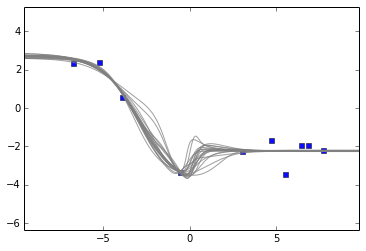

In [104]:
final_temperature = 1.0
for num_partial_data in [2, 5, 10]:
    if num_partial_data < num_train_items:
        partX, partT = X[:,:num_partial_data], T[:num_partial_data]
        all_samples = make_Metropolis_Samples(partX, partT, hyperparameters)
        if num_inputs == 1: 
            plot_curves(partX, partT, X, T, all_samples, final_temperature, in_file,  num_hiddens)